# Exploring expressives in goodreads reviews

В данном ноутбуке проводится анализ экспрессивов из отзывов **goodreads**. Для подробного рассмотрения был выбран экспрессив **"wonderful"**, однако алгоритм можно протестировать и на других примерах.

## Анализ экспрессива "wonderful"

Рассмотрим несколько примеров, которые показывают, что слово "wonderful" можно отнести к экспрессиву.

1) **Полярность**. Очевидно, что слово "wonderful" обладает позитивной полярностью, так как в большинстве случаев оно используется для выражения положительных эмоций:
<br>
— What a wonderful day!
<br>
— It was a wonderful experience.
<br>
К исключениям можно отнести случаи с отрицанием и противопоставлениями:
<br>
— Trust me, he's not that wonderful.
<br>
— That is wonderful, but unfortunately not enough.
<br>

2) **Интенсивность**. В словаре Cambridge Dictionary слово "wonderful" определяется как "*extremely good*". Можно считать, что "wonderful" обладает большей интенсивностью, чем слово "good":
<br>
 — This book is good.
<br>
— This book is wonderful.
<br>

3) **Личный взгляд говорящего.** Слово "wonderful" выражает субъективное мнение говорящего о предмете разговора. Рассмотрим следующее предложение:
<br>
—  What a wonderful book!
<br>
То, что говорящий считает книгу замечательной, еще не означает, что таковой ее считают все читатели.
<br>
4) **Возможность повторения для усиления эффекта**
<br>
— Thank you, Evan, you're a wonderful, wonderful guy.
<br>
— I want to say, without a doubt, this is a wonderful, wonderful, absolutely wonderful movie!
<br>

**Предположительный профиль экспрессива "wonderful"**
<br>
Если исследовать экспрессив "wonderful"  в контексте положительных, нейтральных и негативных отзывов, то можно предположить, что профиль экспрессива будет J-образный. То есть, чем положительнее будет отзыв, тем больше будет вероятность встретить в этом отзыве экспрессив "wonderful".
<br>


## Импорт библиотек и обзор данных

In [110]:
# импорт библиотек
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

В рамках данной работы был создан корпус в рецензиями на книги с сайта goodreads.com. Оценка книг на данном сайте осуществляется по 5-ти бальной шкале.

In [116]:
# считывание данных из файла
books = pd.read_csv("goodreads_reviews_dataset.csv")
# оставляем только название книги, текст отзыва и рейтинг
books = books[['book_title', 'text', 'rating']]
books = books[books['text'].notna()]
books = books[books['rating'].notna()]
books.head()

,book_title,text,rating
0,Four Blondes,CW: eating disorders and fat shaming (so much ...,1.0
1,Four Blondes,This book doesn't even deserve one star. This ...,1.0
2,Four Blondes,I'm not quite sure what the author was going f...,2.0
3,Four Blondes,“James is scared about his work. Every time he...,2.0
4,Four Blondes,Bushnell is one of the worse writers of all ti...,1.0


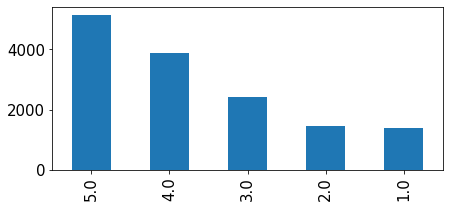

In [117]:
# распределение классов
books['rating'].value_counts().plot(kind="bar", figsize=(7,3))

plt.tick_params(labelsize=15)
plt.show()

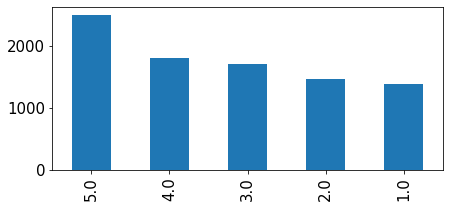

In [118]:
# сделаем распределение более равномерным

books[books["rating"] == 3.0] = books[books["rating"] == 3.0][0:1700]
books[books["rating"] == 4.0] = books[books["rating"] == 4.0][0:1800]
books[books["rating"] == 5.0] = books[books["rating"] == 5.0][0:2500]

books['rating'].value_counts().plot(kind="bar", figsize=(7,3))
plt.tick_params(labelsize=15)
plt.show()

## Моделирование корпуса для экспрессива. Регрессионные модели

In [111]:
class Expressive:
    """ Класс для анализа экспрессива """

    def __init__(self, word_string):
        self.word_string = word_string
        #self.log_odds_distribution = self.calculate_log_odds()
        
    def calculate_log_odds(self):
        # функция для подсчета log-odds распределения экспрессива 
        
        log_odds_distribution = {}
        expressive_len = len(self.word_string)
    
        # Цикл по 5-ти классам
        for rating in tqdm(range(1,6)):
            count_xn_R = 0
            countn_R = 0
            # получение рецензий с оценкой rating
            rows = books.loc[books['rating'] == rating]
            # цикл по всем рецензиям класса
            for review_text in rows['text']:
                tokenized_review = word_tokenize(review_text) # токенизация рецензии
                # подсчет числа токенов длины, равной длине экспрессива
                filtered = [filter(lambda x: len(x) == self.expressive_len, tokenized_review)]
                countn_R += len(filtered)
                # теперь берем только те рецензии, где есть заданный экспрессив
                if self.word_string in review_text:
                    count_xn_R += review_text.split().count(self.word_string)
            log_odds_distribution[float(rating)] = np.log(count_xn_R/(countn_R - count_xn_R))
    
        return log_odds_distribution

    def get_profile(self):
        log_odds_distribution = self.calculate_log_odds()
        # графическая интерпретация профиля на основе распределения
        x = np.array([-2, -1, 0, 1, 2])
        y = log_odds_distribution.values()

        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([-2, -1, 0, 1, 2])

        plt.scatter(x, y)
        plt.show()
        
    def build_regression_models(self):
        log_odds_distribution = self.calculate_log_odds()
        # создание и визуализация регрессионных моделей
        x = np.array([-2, -1, 0, 1, 2])
        y = np.array([*log_odds_distribution.values()])


        # Polynomial Regression
        mymodel = np.poly1d(np.polyfit(x, y, 3))
        myline = np.linspace(-2,2)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([-2, -1, 0, 1, 2])
        plt.scatter(x, y)
        plt.plot(myline, mymodel(myline))

        # Linear Regression 
        k, d = np.polyfit(x, y, 1)
        y_pred = k*x + d
        plt.plot(x, y, '.')
        plt.plot(x, y_pred)

        plt.show()

In [112]:
# создание объекта класса Expressive для слова "wonderful"
wonderful_expressive = Expressive('wonderful')

Построим профиль экспрессива. Можно заметить, что профиль напоминает J-образную форму.

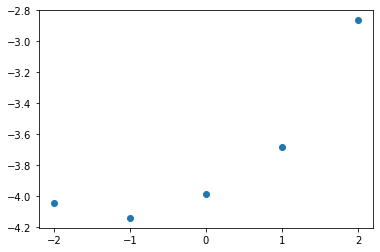

In [113]:
wonderful_expressive.get_profile()

Построим две модели для профиля: линейную регрессию и квадратичную регрессию. Из графика видно, что J-образный профиль лучше всего иллюстрирует квадратичная регрессия.

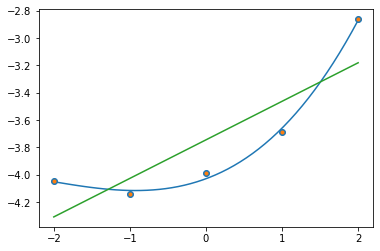

In [115]:
wonderful_expressive.build_regression_models()

## Анализ результатов

Рассмотрим примеры вхождения экспрессива "wonderful" в различных рецензиях с разными оценками.


**Пример рецензии с оценкой 1** 
<br>
(самый "негативный" отзыв)

Из отзыва видно, что слово 'wonderful' в данном случае относится к другой книге, которая была прочитана автором отзыва.

In [64]:
one_star_reviews = books[books["rating"] == 1.0]
one_star_reviews = one_star_reviews[one_star_reviews['text'].str.contains('wonderful')]
one_star_reviews['text'][3631]

"I could only pick one year for when I read this book, but the truth is that I started it in 1991 and read 100 pages every year until I finished the damn thing in 1998. This book was horrific. There was no point, no enjoyment, no anything save for a harrowing description, 900 pages in length, of some sad sack in a tuberculosis sanitarium. The only reason I even finished the book was that I refused to let it defeat me.It wasn't until a friend I respect above all others urged me, pleaded with me, begged me to give Mann another chance that I, with much trepidation, read Buddenbrooks which is a wonderful novel and only makes me really truly wonder what in the name of Pete Mann was thinking when he wrote The Magic Mountain: easily the worst book masquerading as a good book I have ever read."

**Пример рецензии с оценкой 3**
<br>
В данном случае экспрессив "wonderful" имеет отношение к рецензируемой книге: 
<br>
*There was **wonderful suspense** leading up to the climax*

In [68]:
three_star_reviews = books[books["rating"] == 3.0]
three_star_reviews = three_star_reviews[three_star_reviews['text'].str.contains('wonderful')]
three_star_reviews['text'][524]

'I was forced to read this book for my East/West Studies class, and it was actually not that bad. There was wonderful suspense leading up to the climax, and the conclusion seemed fitting when taking into account the greek mythology. '

**Пример рецензии с оценкой 5**
<br>
В данной рецензии экспрессив "wonderful" встречается дважды:
<br>
— Dionysus can be **wonderful** but also terrible.
<br>
— This has been a **wonderful** introduction to Ancient Greek plays and I shall probably read more of them!

In [84]:
five_star_reviews = books[books["rating"] == 5.0]
five_star_reviews = five_star_reviews[five_star_reviews['text'].str.contains('wonderful')]
five_star_reviews['text'][450]

'This was my first Ancient Greek play and I was very very impressed. Everything was clever and cleverly written, and very, for want of a better word, progressive!My favourite quote by far was:"Dionysus will not make women chaste when they feel passion. But we need to reflect on whether chastity is actuallya part of their natural character and is good for all of themIf it really is, then no modest virgin will ever give in during Bacchic rites."I do think Dionysus was very unreasonable in punishing Cadmus - he was going to join in with the Bacchic ritual! Why should he be punished for the sins of his family? Dionysus can be wonderful but also terrible. It actually made me angry.However, this has been a wonderful introduction to Ancient Greek plays and I shall probably read more of them! Yay!'

Посмотрим, сколько рецензий с экспрессивом "wonderful" было в классах с оценками 1, 3 и 5. Видно, что чем выше оценка в рецензии, тем больше вхождений слова "wonderful" в классе. Это в очередной раз подтверждает J-образную форму профиля для данного экспрессива. 

In [89]:
print(f'Число отзывов с оценкой 1, включающих экспрессив "wonderful": {len(one_star_reviews)}')
print(f'Число отзывов с оценкой 3, включающих экспрессив "wonderful": {len(three_star_reviews)}')
print(f'Число отзывов с оценкой 5, включающих экспрессив "wonderful": {len(five_star_reviews)}')

Число отзывов с оценкой 1, включающих экспрессив "wonderful": 25
Число отзывов с оценкой 3, включающих экспрессив "wonderful": 41
Число отзывов с оценкой 5, включающих экспрессив "wonderful": 165
